In [10]:
import random
from operator import itemgetter
import numpy as np
from scipy.spatial.distance import cdist
from matplotlib import pyplot as plt
import pandas as pd
import networkx as nx

In [423]:
class Location(object):
    def __init__(self, x, y, name):
        self.x = x
        self.y = y
        self.name = name

In [424]:
def compute_sub_distance(subroute: tuple) -> float:
    a, b = subroute
    avec = np.asarray([a.x, a.y]).reshape(-1, 2)
    bvec = np.asarray([b.x, b.y]).reshape(-1, 2)
    return cdist(avec, bvec, metric='euclidean')[0][0]

In [425]:
def compute_route_distance(route: list) -> float:
    route = list(zip(route, route[1::]))
    return sum([compute_sub_distance(sub) for sub in route])

In [426]:
def make_locations(num_locations: int) -> list:
    return [Location(random.uniform(0, 10), random.uniform(0, 10), str(i)) for i in range(0, num_locations)]

In [427]:
def make_individual(locations: int) -> list:
    locs = locations.copy()
    start, end = locs[0:1].copy(), locs[0:1].copy()
    middle = locs[1:].copy()
    random.shuffle(middle)
    return start+middle+end

In [428]:
def make_population(pop_size: int, num_locations: int) -> list:
    locations = make_locations(num_locations)
    population = list()
    for sample in range(0, pop_size):
        route = make_individual(locations)
        population.append(route)
    return population

In [429]:
def rank_routes(population: list) -> list:
    all_distances = [compute_route_distance(individual) for individual in population]
    ranking = list(zip(*sorted(zip(all_distances, population), key=itemgetter(0))))
    format_ranking = list()
    for ix, distance in enumerate(ranking[0]):
        format_ranking.append((distance, ranking[1][ix]))
    return format_ranking

In [430]:
def tourn_selection(ranked_pop: list, elite_size: int, tourn_stages: int = 1) -> list:
    selected = list()
    
    # ELITE
    elite, rest = ranked_pop[:elite_size], ranked_pop[elite_size:]
    selected.append(elite[0][1])
    
    # TOURNAMENT
    stage_participants = rest.copy()
    tourn_survivor = None
    for stage in range(0, tourn_stages):
        stage_survivor = list()
        perm = np.random.permutation(len(stage_participants))
        rand = np.asarray(stage_participants)[perm]
        if len(rand) % 2 > 0:
            rand = rand[:-1]
        matches = rand.reshape(int(len(rand)/2), 2, 2)
        
        for (a, b) in matches:
            if a[0] <= b[0]:
                winner = a
            else:
                winner = b
            stage_survivor.append(winner)
        stage_participants = stage_survivor
    tourn_survivor = stage_participants  
    
    survivors = [(fitness, loc) for fitness,loc in elite] + [(fitness, loc) for fitness,loc in np.asarray(tourn_survivor)]
            
    return survivors

In [431]:
def prob_selection(ranked_pop: list, elite_size: int) -> list:
    selected = list()
    
    perf_fit = ranked_pop[0][0]-1 # BUGGED
    
    # PROBABILITY OF SURVIVAL DIRECTLY DEPENDS ON DISTANCE
    survivors = list()
    for distance, route in ranked_pop:
        fitness = perf_fit/distance
        if np.random.binomial(1, fitness) == 1:
            survivors.append((distance, route))
            
    return survivors

In [432]:
def breed_population(pool: list, elite_size: int) -> list:
    children = []
    
    elite = [x[1] for x in sorted(pool, key=itemgetter(0))[:elite_size]]
    children += elite
    
    pool = random.sample(pool, len(pool))
    
    for i in range(0, len(pool)-elite_size):
        new_children = breed(pool[i][1], pool[len(pool)-i-1][1])
        children += new_children
        
    return children

In [433]:
def breed(a: list, b: list) -> list:
    
    nums = np.random.randint(1, len(a)-1, 2)
    startGene, endGene = min(nums), max(nums)
    children = list()
    
    for i in range(1, 3):
        if i % 2 == 0:
            pa = a.copy()
            pb = b.copy()
        else:
            pa = b.copy()
            pb = a.copy()

        childb = pb.copy()

        insert = pa[startGene:endGene]
        replaced = [x for x in pb[startGene:endGene] if x not in insert]

        childb[startGene:endGene] = insert
        dupl = list(set([x for x in childb if childb.count(x) > 1 and x != a[0]]))
        area = range(startGene, endGene)
        rpcnt = 0
        for ix, gene in enumerate(childb):
            if ix in area:
                continue
            elif gene in dupl:
                childb[ix] = replaced[rpcnt]
                rpcnt +=1
        children.append(childb)
    return children

In [434]:
def swap_mutate(individual: list, chance: float) -> list: # chance of mutation for each gene
    for topos in range(1, len(individual)-1):
        if np.random.binomial(1, chance) == 0:
            continue
            
        frompos = int(random.random() * len(individual))
        if (frompos in [0, len(individual)-1]) or (frompos == topos):
            continue
        
        loca = individual[frompos]
        locb = individual[topos]
        individual[frompos] = locb
        individual[topos] = loca
        
    return individual

In [435]:
def swap_mutate_population(population: list, chance: float) -> list:
    return [swap_mutate(ind, chance) for ind in population]

In [436]:
def compute_metrics(ranked_pop: list):
    mean_dist = np.mean([x[0] for x in ranked_pop])
    min_dist = np.min([x[0] for x in ranked_pop])
    max_dist = np.max([x[0] for x in ranked_pop])
    pop_size = len(ranked_pop)
    return {
        "mean_dist": mean_dist,
        "min_dist": min_dist,
        "max_dist": max_dist,
        "pop_size": pop_size
    }

In [584]:
def evolve(population: list, selection: str, elite_size: int, chance: float,
           tournament_stages: int = 1) -> (list, dict, list):  
    ranked_pop = rank_routes(population)
    metrics = compute_metrics(ranked_pop)
    if selection == "prob":
        sel = prob_selection(ranked_pop, elite_size)
    elif selection == "tourn":
        sel = tourn_selection(ranked_pop, elite_size, tournament_stages)
    else:
        raise ValueError('unknown selection method')
    children = breed_population(sel, elite_size)
    next_gen = swap_mutate_population(children, chance)
    return next_gen, metrics, rank_routes(next_gen)[0]

In [585]:
def plot_progress(metrics: list, exclude: list = ["pop_size"]) -> None:
    plt.figure(figsize=(12, 8))
    plt.title('Evolutionary Progress', size=20)
    plt.xlabel("Evolutionary Steps")
    plt.ylabel("Total Euclidean Distance Needed")
    keys = list(metrics[0].keys())
    print(pd.DataFrame.from_records(total_metrics))
    for key in keys:
        key_final = dict()
        key_values = list()
        for run in metrics:
            key_values.append(run[key])
            
        key_final[key] = key_values
        
        if key not in exclude:
            plt.plot(list(key_final.values())[0], label=key)
    plt.legend()
    plt.show()

In [586]:
def plot_path(indiv: list) -> None:
    coords = dict()
    path = list()

    for ix, loc in enumerate(indiv):
        coords[int(loc.name)] = (loc.x, loc.y)
        if ix < len(indiv) -1:
            path.append((int(loc.name), int(indiv[ix+1].name)))
    
    dist = compute_route_distance(indiv)
    print('Total distance covered: '+str(dist))
    g = nx.DiGraph()
    for node, coord in coords.items():
        g.add_node(node, pos=coord)
    g.add_edges_from(path)
    nx.draw(g, coords, with_labels=True)

In [587]:
EVOLUTION_STEPS = 500
NUM_INDIVIDUALS = 2000
NUM_LOCATIONS = 50
ELITE_SIZE = 50
MUTATE_CHANCE = 0.01
OFFSET_EARLY_STOPPING = 20
SOFT_PATIENCE = 100
CONVERGENCE_CRITERIUM = 0.01
SELECTION = 'tourn'

total_metrics = list()

population = make_population(NUM_INDIVIDUALS, NUM_LOCATIONS)
min_dist = list()
for step in range(0, EVOLUTION_STEPS):
    population, metrics, best = evolve(population, SELECTION, ELITE_SIZE, MUTATE_CHANCE)
    total_metrics.append(metrics)
    min_dist.append(metrics["min_dist"])
    if (len(min_dist) >= OFFSET_EARLY_STOPPING):
        cum_diff = [abs(t - s) for s, t in zip(min_dist[-SOFT_PATIENCE:], min_dist[-SOFT_PATIENCE:][1:]) if (t - s) < 0]
        if np.mean(cum_diff) <= 0.5:
            break

       max_dist   mean_dist    min_dist  pop_size
0    315.503295  264.697419  212.703058      2000
1    306.563354  257.682167  211.786751      2000
2    303.168142  252.670782  207.377108      2000
3    294.687745  249.233854  199.435255      2000
4    299.455526  246.559993  188.421802      2000
5    294.545732  244.138282  186.623907      2000
6    292.452228  241.943673  186.623907      2000
7    293.205410  240.353460  170.908124      2000
8    295.261027  237.727047  170.908124      2000
9    293.717838  236.520053  170.908124      2000
10   301.118952  235.280021  170.908124      2000
11   290.823246  234.055621  170.908124      2000
12   292.956390  234.182208  170.908124      2000
13   291.820577  233.312444  170.908124      2000
14   288.305481  232.692253  170.908124      2000
15   291.096641  232.251150  169.341735      2000
16   293.688746  231.660821  170.908124      2000
17   296.722479  231.429009  170.908124      2000
18   290.037846  230.927903  168.359264      2000


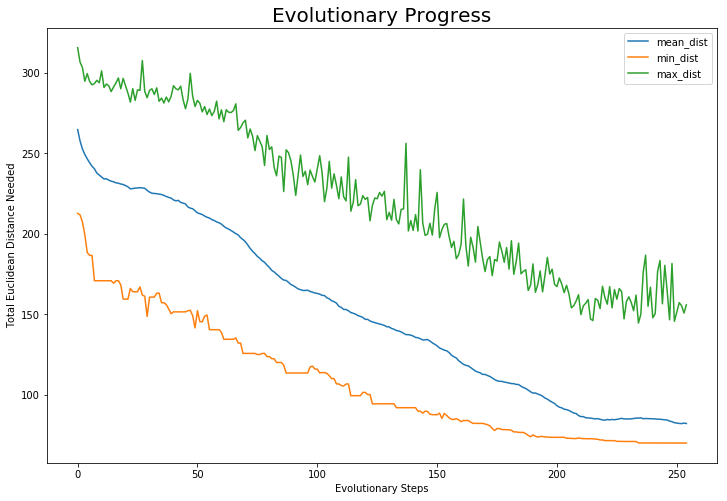

Total distance covered: 70.20469752271107


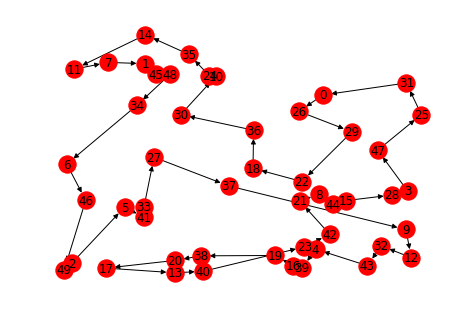

In [588]:
plot_progress(total_metrics)
plot_path(best[1])